## Bernstein-Vazirani Algorithm implemented with Qiskit:

Imagine I have a secret number and you are to guess what that number is. How many tries do you think you will need?

To put it into context, say we have the binary string "1011011" with 7 bits. Classically, a computer would require 7 queries to get that right. First, for the 7th bit, it will perform an AND operation between "1" and the 7th bit. If the result is 1, the computer will be sure that the 7th bit is 1; whereas, if the result is 0, the computer will know that the last bit is 0. Similarly, for every bit starting from the last, the computer will have to make as many queries as the number of bits (n) in the string to finally fetch the secret value. However, quantum computer promises to guess the number with a single shot! The quantum algorithm, named after Ethan Bernstein and Umesh Vazirani, put forth in 1992, explores more on how this can be made possible.

In this tutorial@q-munity, we will walk you through the Qiskit implementation of Bernstein-Vazirani algorithm.

First, let us import the standard qiskit libraries

In [ ]:
# Importing standard Qiskit libraries:   
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
%matplotlib inline

Bernstein-Vazirani  algorithm can be refered as an extension of [Deutsch-Jozsa algorithm](https://www.qmunity.tech/tutorials/deutschs-algorithm). In both cases, we depend on an oracle based model. 

Let us first solve a number-specific example.
When secret_number = '1011001' (7-bit long string), we need to initialize a quantum circuit with 7+1 qubits and 7 classical bits  where we will store the results.

### Step # 1:

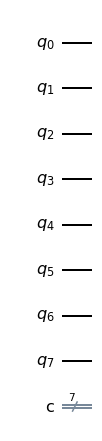

In [ ]:
circuit = QuantumCircuit(7+1,7)
circuit.draw("mpl")

As usual, we need to create a superposition (|+> state) of all input quantum bits to leverage interference of qubits. The last (extra) qubit is, however, put into a |-> state:

### Step # 2:

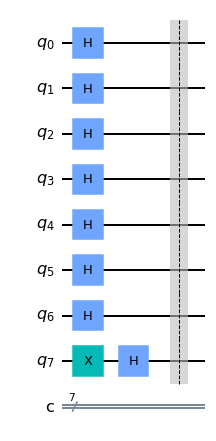

In [ ]:
circuit.h([0,1,2,3,4,5,6])
circuit.x(7)
circuit.h(7)

circuit.barrier()
circuit.draw("mpl")

Now, for each '1' we see in the bit string, we will add a CX-gate with control on the succeeding qubit: 

### Step # 3:

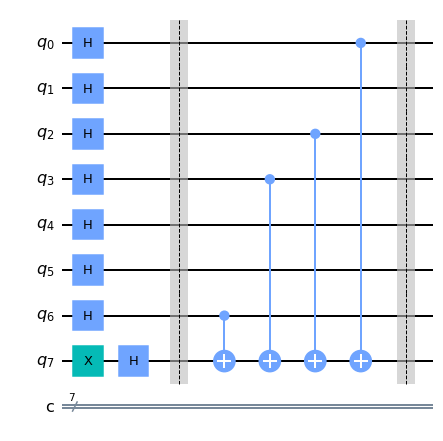

In [ ]:
circuit.cx(6,7)
circuit.cx(3,7)
circuit.cx(2,7)
circuit.cx(0,7)

circuit.barrier()
circuit.draw("mpl")

The series of CX-gates bounded by two barriers is analogous to Oracle operation- exclusively for the provided bit-string. (Generalizing later). Next, we will again have to apply Hadamard gate on all qubits and finally measure.

### Step # 4:

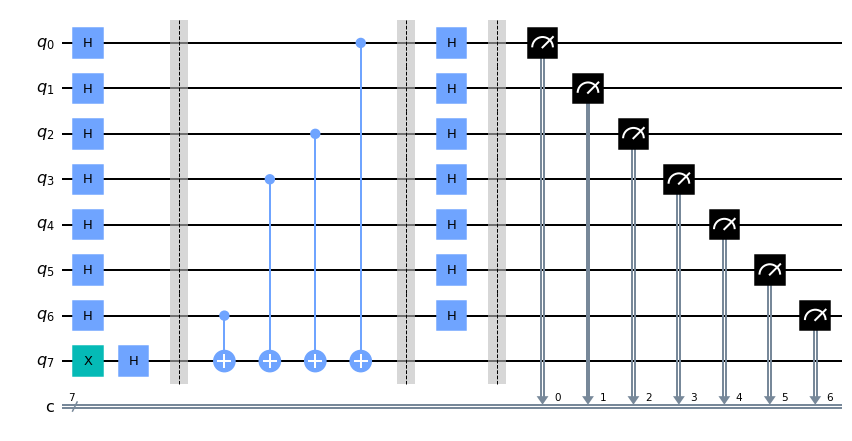

In [ ]:
circuit.h([0,1,2,3,4,5,6])

circuit.barrier()

circuit.measure([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])

circuit.draw("mpl")

Now, let us run the circuit on a simulator to see if it really matches with the number presumed:

### Step # 5:

{'1001101': 1}


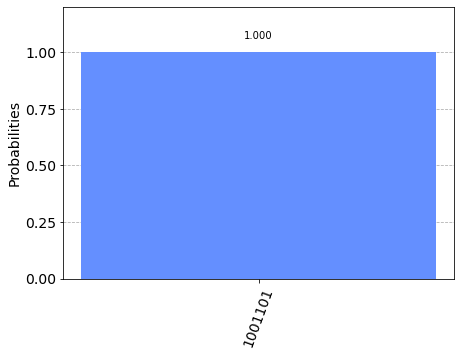

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots = 1).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

As we can see, the alrorithm, in fact, with a single shot guessed the secret number! But, we cannot always know beforehand what the number is. So we need a more genralized circuit that would work independent of the bit-string. So the oracle function would take the following input:
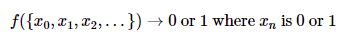

In [ ]:
secret_number = input("Input a Binary String of your choice ")  
## Not more than 4 bits if you want to run on a real quantum device later on

Input a Binary String of your choice 1010


As we initialize the qubits in |+> state through applying n Hadamard gates, we get the following state:

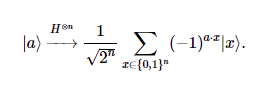

We will apply an X-gate on the ;last qubit before Hadamard gate

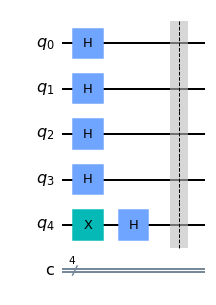

In [ ]:
bv_circ = QuantumCircuit(len(secret_number)+1,len(secret_number))

bv_circ.h(range(len(secret_number)))
bv_circ.x(len(secret_number))
bv_circ.h(len(secret_number))

bv_circ.barrier()

bv_circ.draw("mpl")

Now let us construct the oracle: U_f which transforms:      
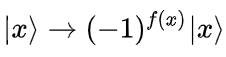


Here, similar to the previous example, the Oracle performs a CX-operation on the qubit for each "1" in the bit-string. However, in this case we ourselves will not know when to apply C-NOT gate, rather we will code for a blackbox that will do the task for us. In this case, the CX gate denotes a mod 2 operation.The oracle function, this time unlike Deutsch's algorithm does not require to be balanced.

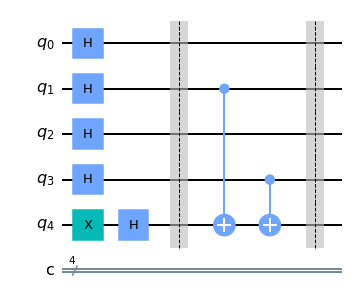

In [ ]:
for digit, query in enumerate(reversed(secret_number)):
    if query == "1":
        bv_circ.cx(digit, len(secret_number))
              
bv_circ.barrier()

bv_circ.draw("mpl")

After the oracle query, we need to apply Hadamard gates for unitary operation. To wrap-up, add measurement gates:

In [ ]:
bv_circ.h(range(len(secret_number)))

bv_circ.barrier()

bv_circ.measure(range(len(secret_number)),range(len(secret_number)))

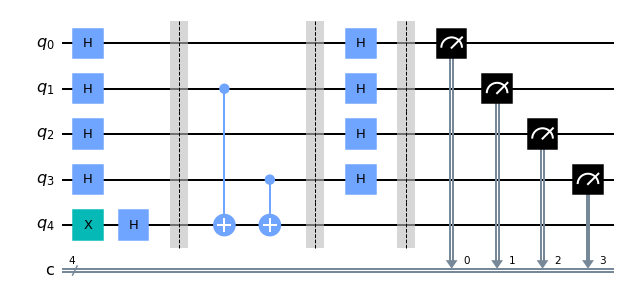

In [ ]:
bv_circ.draw("mpl")

Let us check if our generalized circuit works! (Make sure you run the circuit on the simulator with a single shot)

{'1010': 1}


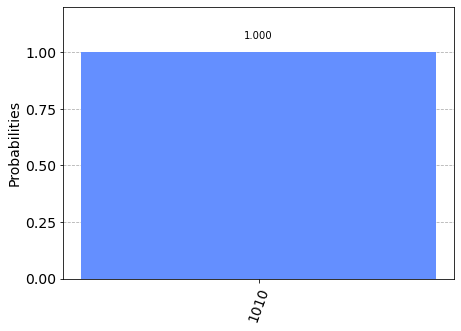

In [ ]:
simulator = Aer.get_backend("qasm_simulator")
result = execute(bv_circ, backend = simulator, shots = 1).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

If you want to run the circuit on a real quantum device:

In [ ]:
# Enabling our IBMQ accounts to get the least busy backend device with less than or equal to 5 qubits
IBMQ.enable_account('IBM Q API Token')
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


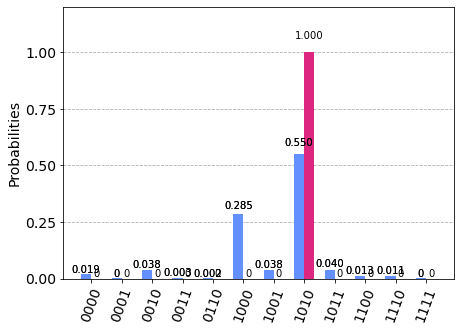

In [ ]:
exp = execute(bv_circ, backend, shots = 1024)
result_exp = exp.result()
counts_exp = result_exp.get_counts()
plot_histogram([counts_exp,counts])